# AI - FasterRCNN Inference

https://www.kaggle.com/tomchaniii/ai-fasterrcnn-inference

In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

DIR_INPUT = '/kaggle/input/global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

DIR_WEIGHTS = '/kaggle/input/ai-fasterrcnn-train'

WEIGHTS_FILE = f'{DIR_WEIGHTS}/fasterrcnn_resnet50_fpn.pth'

In [2]:
test_df = pd.read_csv(f'{DIR_INPUT}/sample_submission.csv')
test_df.shape

(10, 2)

In [3]:
class WheatTestDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [4]:
# Albumentations
def get_test_transform():
    return A.Compose([
        # A.Resize(512, 512),
        ToTensorV2(p=1.0)
    ])


In [5]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the trained weights
model.load_state_dict(torch.load(WEIGHTS_FILE))
model.eval()

x = model.to(device)

In [7]:
def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = WheatTestDataset(test_df, DIR_TEST, get_test_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

In [8]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

In [9]:
detection_threshold = 0.5
results = []

for images, image_ids in test_data_loader:

    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }

        
        results.append(result)


In [10]:
results[0:2]

[{'image_id': 'aac893a91',
  'PredictionString': '0.9884 615 915 78 106 0.9837 73 3 94 156 0.9808 593 779 88 117 0.9771 178 565 109 179 0.9727 358 530 92 80 0.9710 462 858 75 87 0.9660 820 704 101 204 0.9629 237 843 133 77 0.9604 31 449 94 150 0.9597 63 856 121 67 0.9554 88 617 121 69 0.9543 332 662 113 150 0.9537 558 531 127 178 0.9337 538 56 155 191 0.9317 739 772 76 114 0.9303 692 385 118 176 0.9216 315 3 60 60 0.8482 354 262 118 155 0.7825 247 89 130 139 0.7644 337 896 61 62'},
 {'image_id': '51f1be19e',
  'PredictionString': '0.9933 614 90 149 171 0.9843 281 471 123 115 0.9649 843 279 123 180 0.9552 821 94 100 70 0.9514 507 470 193 101 0.9503 772 888 138 87 0.9397 815 765 93 80 0.9296 354 143 91 162 0.8807 40 1 63 67 0.8616 2 377 52 95 0.8501 653 791 105 75 0.8293 254 125 85 95 0.8168 699 921 77 77 0.7403 213 938 81 82 0.6563 71 696 126 202 0.6283 572 606 100 99 0.5302 907 697 101 64'}]

In [11]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()

,image_id,PredictionString
0,aac893a91,0.9884 615 915 78 106 0.9837 73 3 94 156 0.980...
1,51f1be19e,0.9933 614 90 149 171 0.9843 281 471 123 115 0...
2,f5a1f0358,0.9888 887 647 83 135 0.9882 550 400 75 92 0.9...
3,796707dd7,0.9826 902 335 91 81 0.9775 945 75 75 94 0.975...
4,51b3e36ab,0.9966 518 357 292 120 0.9964 232 639 95 159 0...


In [12]:
sample = images[1].permute(1,2,0).cpu().numpy()
boxes = outputs[1]['boxes'].data.cpu().numpy()
scores = outputs[1]['scores'].data.cpu().numpy()

boxes = boxes[scores >= detection_threshold].astype(np.int32)

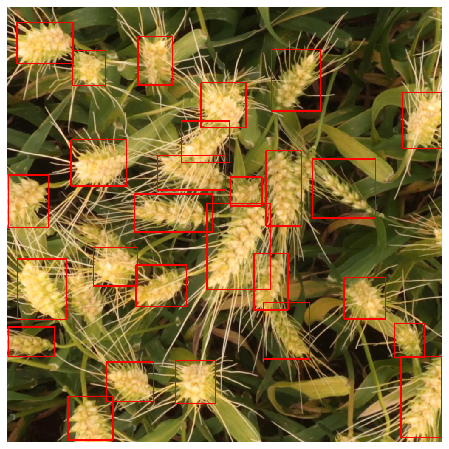

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)
    
ax.set_axis_off()
ax.imshow(sample)

In [14]:
test_df.to_csv('submission.csv', index=False)